
# Healthcare Insurance Analytics Dashboard — Notebook

This notebook replicates the core analyses from the **Healthcare Insurance Analytics Dashboard** project and prepares **visualizations** and **exported aggregates** you can also use in Tableau.

**What you'll get:**
- Cleaned data with parsed dates and standardized column names
- KPIs & summaries
- Visuals:
  1. Total paid by insurance by **Provider Specialty** (bar, highlight top 2)
  2. Monthly **Commercial vs Medicare** totals (line plot)
  3. **Insurance Paid vs Patient Deductible** (scatter, filtered ≤ $2,000) + trendline
  4. **Quarterly spend by State** (bubble chart; top states)
- CSV exports for Tableau

> Dataset fields & dashboard specs were taken from the provided documents. 


## Setup & Helpers

In [1]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure plots display nicely
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

# Create output folders
EXPORT_DIR = Path("exports")
EXPORT_DIR.mkdir(exist_ok=True, parents=True)

DATA_CANDIDATES = [
    # preferred local relative path
    Path("data/ABC_Healthcare_Claims.xlsx"),
    # uploaded path in this environment (fallback)
    Path("ABC Healthcare Company Claims Dataset.xlsx")
]

def find_existing_path(candidates):
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError("Could not find the dataset. Place the Excel file at 'data/ABC_Healthcare_Claims.xlsx'.")

DATA_PATH = find_existing_path(DATA_CANDIDATES)
DATA_PATH


WindowsPath('ABC Healthcare Company Claims Dataset.xlsx')

## Load Data & Standardize Columns

In [2]:

df = pd.read_excel(DATA_PATH)

# Standardize column names (upper snake: strip spaces, newlines)
def std_col(c):
    c = str(c).strip().replace("\n", " ").replace("\r", " ")
    c = re.sub(r"\s+", "_", c)
    return c.upper()

df.columns = [std_col(c) for c in df.columns]

print("Columns:", list(df.columns))
print("Shape:", df.shape)

# Expected columns (robust matching): map likely variations
wanted = {
    "CLAIM_ID": ["CLAIM_ID"],
    "PATIENT_ID": ["PATIENT_ID"],
    "PATIENT_STATE": ["PATIENT_STATE", "STATE"],
    "PRODUCT_LINE": ["PRODUCT_LINE"],
    "DATE_OF_SERVICE": ["DATE_OF_SERVICE", "SERVICE_DATE", "DOS"],
    "CPT_CODE": ["CPT_CODE"],
    "CPT_DESCRIPTION": ["CPT_DESCRIPTION"],
    "PROVIDER_NPI": ["PROVIDER_NPI", "NPI"],
    "PROVIDER_SPECIALTY": ["PROVIDER_SPECIALTY", "SPECIALTY"],
    "TOTAL_PAID_BY_INSURANCE": ["TOTAL_PAID_BY_INSURANCE", "INSURANCE_PAID", "TOTAL_PAID"],
    "PATIENT_DEDUCTIBLE": ["PATIENT_DEDUCTIBLE", "DEDUCTIBLE", "PATIENT_COPAYMENT", "PATIENT_COPAY"]
}

def pick_col(std_df_cols, candidates):
    # pick first match which exists
    for name in candidates:
        if name in std_df_cols:
            return name
    return None

colmap = {}
for k, opts in wanted.items():
    col = pick_col(df.columns, opts)
    if col is None:
        print(f"WARNING: Could not find column for {k}. Looked for: {opts}")
    colmap[k] = col

colmap


Columns: ['CLAIM_ID', 'PATIENT_ID', 'PATIENT_STATE', 'PRODUCT_LINE', 'DATE_OF_SERVICE', 'CPT_CODE', 'CPT_DESCRIPTION', 'PROVIDER_NPI', 'PROVIDER_SPECIALTY', 'TOTAL_PAID_BY_INSURANCE', 'PATIENT_COPAYMENT']
Shape: (917, 11)


{'CLAIM_ID': 'CLAIM_ID',
 'PATIENT_ID': 'PATIENT_ID',
 'PATIENT_STATE': 'PATIENT_STATE',
 'PRODUCT_LINE': 'PRODUCT_LINE',
 'DATE_OF_SERVICE': 'DATE_OF_SERVICE',
 'CPT_CODE': 'CPT_CODE',
 'CPT_DESCRIPTION': 'CPT_DESCRIPTION',
 'PROVIDER_NPI': 'PROVIDER_NPI',
 'PROVIDER_SPECIALTY': 'PROVIDER_SPECIALTY',
 'TOTAL_PAID_BY_INSURANCE': 'TOTAL_PAID_BY_INSURANCE',
 'PATIENT_DEDUCTIBLE': 'PATIENT_COPAYMENT'}

## Parse Date & Enrich Time Columns

In [3]:

date_col = colmap["DATE_OF_SERVICE"]
if date_col is None:
    raise KeyError("DATE_OF_SERVICE not found. Please update colmap or dataset.")

df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).copy()

df["YEAR"] = df[date_col].dt.year
df["MONTH"] = df[date_col].dt.month
df["MONTH_NAME"] = df[date_col].dt.month_name()
df["YEAR_MONTH"] = df[date_col].dt.to_period("M").astype(str)
df["QUARTER"] = df[date_col].dt.quarter
df["YEAR_QTR"] = df[date_col].dt.to_period("Q").astype(str)

print(df[[date_col, "YEAR", "MONTH", "YEAR_MONTH", "QUARTER", "YEAR_QTR"]].head())


  DATE_OF_SERVICE  YEAR  MONTH YEAR_MONTH  QUARTER YEAR_QTR
0      2017-03-18  2017      3    2017-03        1   2017Q1
1      2017-04-27  2017      4    2017-04        2   2017Q2
2      2018-07-25  2018      7    2018-07        3   2018Q3
3      2018-07-02  2018      7    2018-07        3   2018Q3
4      2018-05-01  2018      5    2018-05        2   2018Q2


## KPIs

In [4]:

paid_col = colmap["TOTAL_PAID_BY_INSURANCE"]
ded_col = colmap["PATIENT_DEDUCTIBLE"]
prod_col = colmap["PRODUCT_LINE"]

total_paid = df[paid_col].sum() if paid_col else np.nan
avg_paid_per_claim = df[paid_col].mean() if paid_col else np.nan
num_claims = df[colmap["CLAIM_ID"]].nunique() if colmap["CLAIM_ID"] else df.shape[0]

kpis = {
    "Total Paid by Insurance": float(total_paid),
    "Avg Paid per Claim": float(avg_paid_per_claim),
    "Number of Claims": int(num_claims)
}

if prod_col:
    kpis["Paid by Product Line"] = df.groupby(prod_col)[paid_col].sum().sort_values(ascending=False).to_dict()

kpis


{'Total Paid by Insurance': 508938.0,
 'Avg Paid per Claim': 555.0032715376227,
 'Number of Claims': 917,
 'Paid by Product Line': {'Medicare': 265764, 'Commercial': 243174}}

## Visualization 1 — Total Paid by Provider Specialty (Top 2 highlighted)

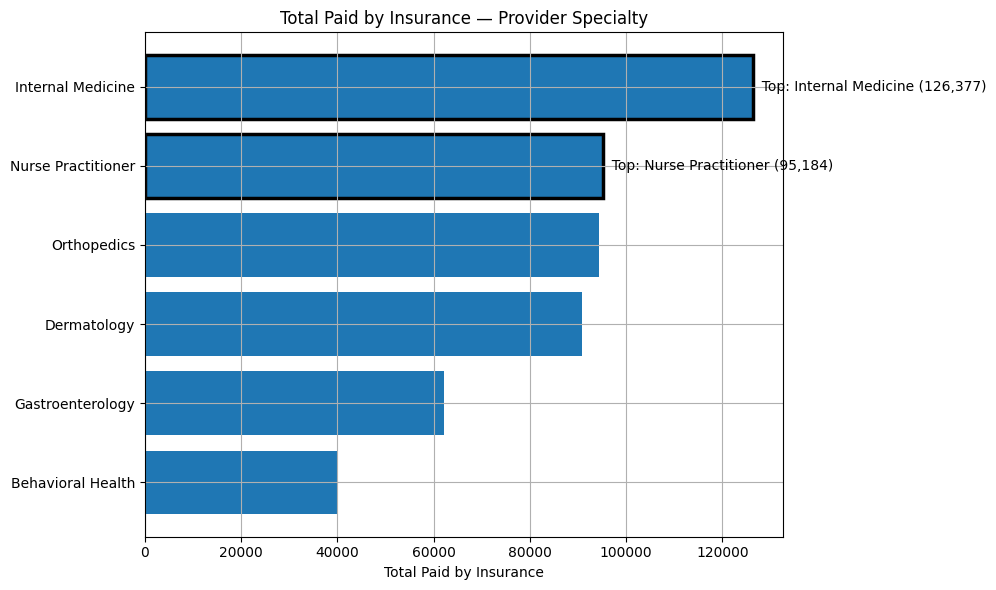

In [5]:

spec_col = colmap["PROVIDER_SPECIALTY"]
if spec_col is None or paid_col is None:
    raise KeyError("Missing PROVIDER_SPECIALTY or TOTAL_PAID_BY_INSURANCE.")

spec = df.groupby(spec_col, dropna=False)[paid_col].sum().sort_values(ascending=False)
top2 = spec.head(2)

fig, ax = plt.subplots()
bars = ax.barh(spec.index[::-1], spec.values[::-1])
ax.set_title("Total Paid by Insurance — Provider Specialty")
ax.set_xlabel("Total Paid by Insurance")

# Highlight top 2 (which are last two in reversed order)
for i, b in enumerate(bars):
    # find label from reversed index back to original order
    label = spec.index[::-1][i]
    if label in top2.index:
        b.set_linewidth(2.5)
        b.set_edgecolor("black")

# Annotate the top 2 values
for label, val in top2.items():
    idx = list(spec.index[::-1]).index(label)
    y = idx
    ax.text(val, y, f"  Top: {label} ({val:,.0f})", va="center")

plt.tight_layout()
plt.show()

# Export table for Tableau
spec.reset_index().rename(columns={spec_col: "PROVIDER_SPECIALTY", paid_col: "TOTAL_PAID"}).to_csv(EXPORT_DIR/"paid_by_specialty.csv", index=False)


## Visualization 2 — Monthly Total Paid by Product Line (Commercial vs Medicare)

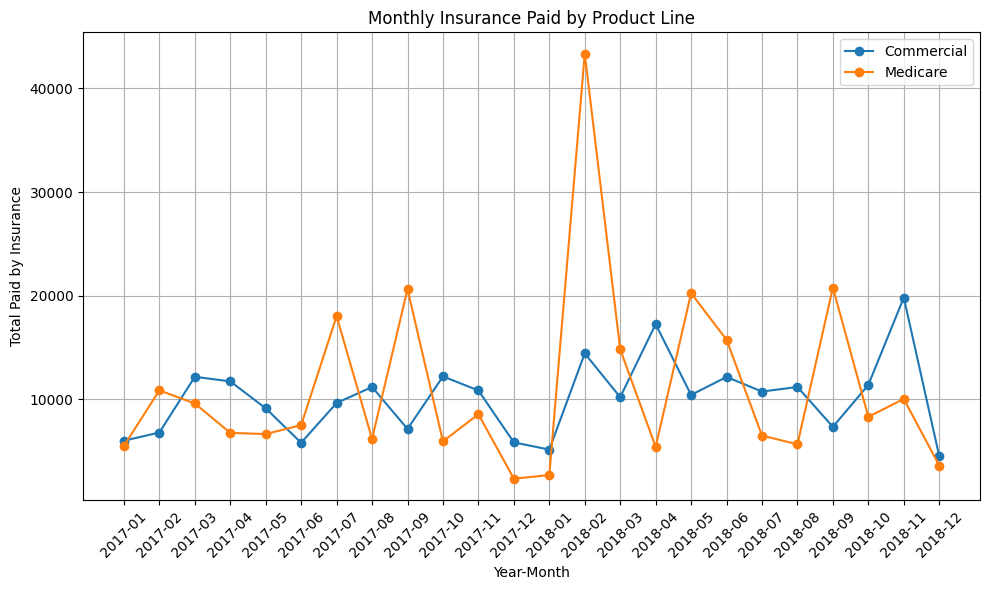

In [6]:

if prod_col is None or paid_col is None:
    raise KeyError("Missing PRODUCT_LINE or TOTAL_PAID_BY_INSURANCE.")

monthly = df.groupby(["YEAR_MONTH", prod_col])[paid_col].sum().reset_index()
# Pivot to columns by product line
pivot = monthly.pivot(index="YEAR_MONTH", columns=prod_col, values=paid_col).fillna(0)
pivot = pivot.sort_index()

fig, ax = plt.subplots()
for col in pivot.columns:
    ax.plot(pivot.index, pivot[col], marker="o", label=str(col))

ax.set_title("Monthly Insurance Paid by Product Line")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Paid by Insurance")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export for Tableau
pivot.reset_index().to_csv(EXPORT_DIR/"monthly_paid_by_product_line.csv", index=False)


## Visualization 3 — Insurance Paid vs Patient Deductible (≤ $2,000) + Trendline

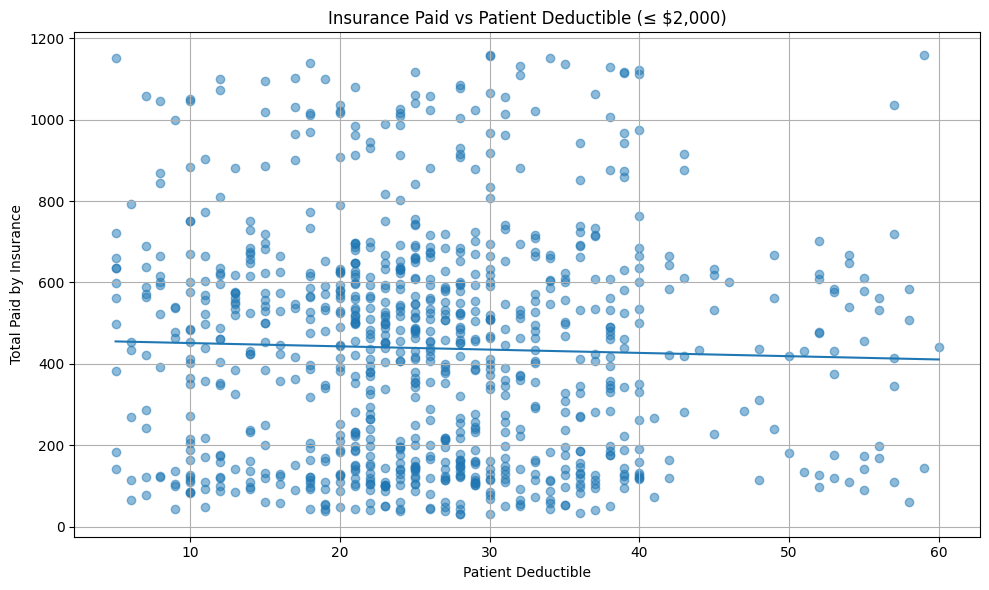

Correlation (filtered ≤ $2,000): -0.03200265688515486


In [7]:

if paid_col is None or ded_col is None:
    raise KeyError("Missing TOTAL_PAID_BY_INSURANCE or PATIENT_DEDUCTIBLE.")

scatter_df = df[[paid_col, ded_col]].dropna().copy()
scatter_df = scatter_df[scatter_df[paid_col] <= 2000]

x = scatter_df[ded_col].values
y = scatter_df[paid_col].values

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5)
ax.set_title("Insurance Paid vs Patient Deductible (≤ $2,000)")
ax.set_xlabel("Patient Deductible")
ax.set_ylabel("Total Paid by Insurance")

# Trendline (simple linear fit)
if len(scatter_df) > 1:
    m, c = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = m * x_line + c
    ax.plot(x_line, y_line)

plt.tight_layout()
plt.show()

# Correlation
corr = float(np.corrcoef(x, y)[0,1]) if len(scatter_df) > 1 else np.nan
print("Correlation (filtered ≤ $2,000):", corr)

# Export for Tableau
scatter_df.rename(columns={paid_col: "TOTAL_PAID_BY_INSURANCE", ded_col: "PATIENT_DEDUCTIBLE"}).to_csv(EXPORT_DIR/"scatter_ins_paid_vs_deductible_le_2000.csv", index=False)


## Visualization 4 — Quarterly Insurance Spend by State (Top States — Bubble Chart)

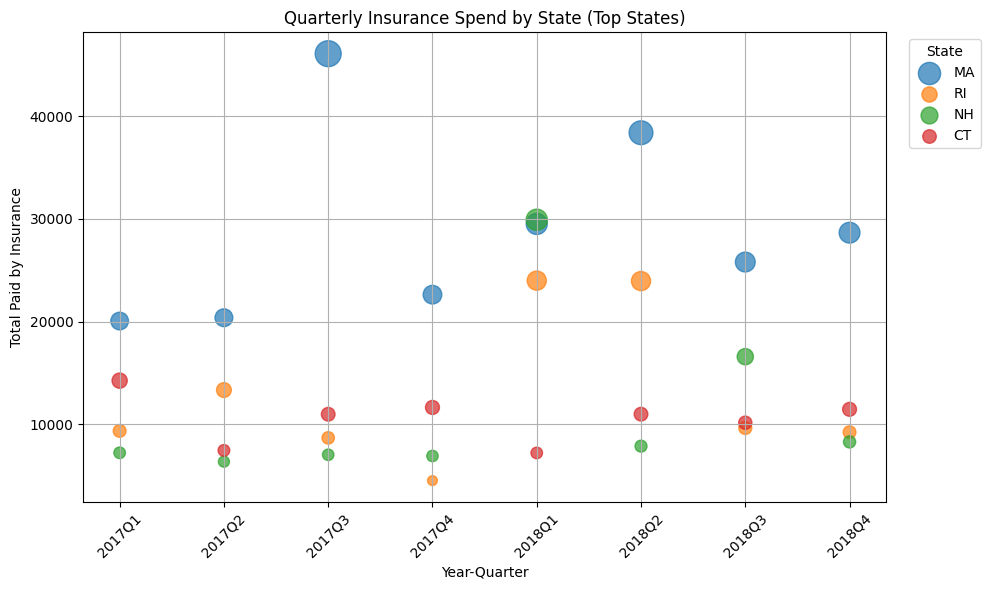

In [8]:

state_col = colmap["PATIENT_STATE"]
if state_col is None or paid_col is None:
    raise KeyError("Missing PATIENT_STATE or TOTAL_PAID_BY_INSURANCE.")

# focus on top N states by total paid
topN = 6
state_totals = df.groupby(state_col)[paid_col].sum().nlargest(topN).index.tolist()
q = df[df[state_col].isin(state_totals)].groupby(["YEAR_QTR", state_col])[paid_col].sum().reset_index()

# Normalize bubble size for readability
size = q[paid_col]
size_norm = 300 * (size - size.min()) / (size.max() - size.min() + 1e-9) + 50

fig, ax = plt.subplots()
for st in state_totals:
    sub = q[q[state_col] == st]
    ax.scatter(sub["YEAR_QTR"], sub[paid_col], s=size_norm[q[state_col]==st], alpha=0.7, label=st)

ax.set_title("Quarterly Insurance Spend by State (Top States)")
ax.set_xlabel("Year-Quarter")
ax.set_ylabel("Total Paid by Insurance")
plt.xticks(rotation=45)
ax.legend(title="State", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Export for Tableau
q.rename(columns={paid_col: "TOTAL_PAID_BY_INSURANCE", state_col: "PATIENT_STATE"}).to_csv(EXPORT_DIR/"quarterly_paid_by_state_top.csv", index=False)
